# Climate change's impact on marine food webs
### Tyler Kloster, Hana Burroughs
  
Expanding on a paper by Kortsh et. all,  
https://royalsocietypublishing.org/doi/10.1098/rspb.2015.1546#d1e354

In [17]:
import pandas as pd
import numpy as np
import networkx as nx
import os

In [18]:
# networkx dosen't accept xlsx format, so first import into a pandas dataframe to work with

dataTitle = 'Boreal_and_Arctic_food_webs_of_the_Barents_Sea.xlsx'
excel = pd.ExcelFile(dataTitle)
borealWeb = pd.read_excel(excel, 'The Boreal food web of the BS')
arcticWeb = pd.read_excel(excel, 'The Arctic food web of the BS')

In [19]:
borealLabels = borealWeb.columns.tolist()
arcticLabels = arcticWeb.columns.tolist()

borealNames = list(borealWeb.iloc[:, 0])
arcticNames = list(arcticWeb.iloc[:, 0])

borealSize = borealWeb.shape
arcticSize = arcticWeb.shape

In [ ]:
borealAdjacency = [[] for x in range(borealSize[0])]
arcticAdjacency = [[] for x in range(arcticSize[0])]
for i in range(borealSize[0]):
    for j in range(2, borealSize[1]):
        borealAdjacency[i].append(borealWeb.iloc[i, j])
for i in range(arcticSize[0]):
    for j in range(2, arcticSize[1]):
        arcticAdjacency[i].append(arcticWeb.iloc[i, j])

In [20]:
# Dictionaries to make transfering from scientific names to the shortened label

borealNameToLabel = {}
arcticNameToLabel = {}
for i in range(len(borealNames)):
    borealNameToLabel[borealNames[i]] = borealLabels[i + 2]
for i in range(len(arcticNames)):
    arcticNameToLabel[arcticNames[i]] = arcticLabels[i + 2]

In [21]:
# Double checking all species were loaded (Paper cites 233 unique species)

uniqueNames = borealLabels.copy()[2:]
for i in arcticLabels:
    if (i not in uniqueNames):
        uniqueNames.append(i)

print(len(uniqueNames))

235


In [22]:
# If you want to remake the .gml files, set these to True

generateBorealData = False
generateArcticData = False 

In [23]:
# Builds the .gml file based on the adjacency matrix given in the .xlsx format

if (generateBorealData):
    with open("Boreal_Data.gml", "w") as gmlFile:
        # initialize the file
        gmlFile.write('graph\n')
        gmlFile.write('[\n')
        gmlFile.write('  directed 1\n')

        # set all nodes to have a numerical id and the abreviation as the label
        for i in range(borealSize[0]):
            gmlFile.write('  node\n  [\n')
            gmlFile.write('    id ' + str(i) + '\n')
            gmlFile.write('    label "' + str(borealWeb.iloc[i, 1]) + '"\n')
            gmlFile.write('  ]\n')

        # set the edges only where there is a 1 in the adjacency matrix
        for i in range(borealSize[0]):
            for j in range(2, borealSize[1]):
                if (borealWeb.iloc[i, j] == 1):
                    gmlFile.write('  edge\n  [\n')
                    gmlFile.write('    source ' + str(i) +'\n')
                    gmlFile.write('    target ' + str(j - 2) + '\n')
                    gmlFile.write('  ]\n')
    
        gmlFile.write(']')

In [24]:
if (generateArcticData):
    with open("Arctic_Data.gml", "w") as gmlFile:
        gmlFile.write('graph\n')
        gmlFile.write('[\n')
        gmlFile.write('  directed 1\n')
    
        for i in range(arcticSize[0]):
            gmlFile.write('  node\n  [\n')
            gmlFile.write('    id ' + str(i) + '\n')
            gmlFile.write('    label "' + str(arcticWeb.iloc[i, 1]) + '"\n')
            gmlFile.write('  ]\n')
    
        for i in range(arcticSize[0]):
            for j in range(2, arcticSize[1]):
                if (arcticWeb.iloc[i, j] == 1):
                    gmlFile.write('  edge\n  [\n')
                    gmlFile.write('    source ' + str(i) +'\n')
                    gmlFile.write('    target ' + str(j - 2) + '\n')
                    gmlFile.write('  ]\n')
    
        gmlFile.write(']')

In [25]:
# load the gml files

borealGraph = nx.read_gml('Boreal_Data.gml', label='id')
arcticGraph = nx.read_gml('Arctic_Data.gml', label='id')
borealGLabels = nx.get_node_attributes(borealGraph, "label")
arcticGLabels = nx.get_node_attributes(arcticGraph, "label")

In [26]:
def trophic_position(G):
    trophic_levels = {}
    
    basal_species = [node for node in G.nodes() if G.in_degree(node) == 0]
    
    # Assign trophic level 1 to basal species
    for species in basal_species:
        trophic_levels[species] = 1
    
    # Iteratively calculate trophic levels for other species
    while len(trophic_levels) < len(G):
        for node in G.nodes():
            if node not in trophic_levels:
                prey = list(G.predecessors(node))
                if all(p in trophic_levels for p in prey):
                    trophic_levels[node] = 1 + sum(trophic_levels[p] for p in prey) / len(prey)
    
    return trophic_levels
    

In [27]:
# trophic_levels = trophic_position(borealGraph)

# for node, level in trophic_levels.items():
#     print(f"{G.nodes[node]['label']}: {level:.2f}")

In [28]:
def fraction_self_feeding(G):
    adj_matrix = nx.to_numpy_array(G)
    self_feeding_count = np.sum(np.diag(adj_matrix) != 0)
    total_species = G.number_of_nodes()
    return self_feeding_count / total_species

In [29]:
#boreal_graph metrics 
S = borealGraph.number_of_nodes()
L = borealGraph.number_of_edges()
C = L/S**2
LD = L/S
meanPath = nx.average_shortest_path_length(borealGraph)
Can = fraction_self_feeding(borealGraph)
# clustering = nx.transitivity(borealGraph)

# DAMN IT THAT'S NOT RIGHT???
clustering_coefficient = nx.average_clustering(borealGraph)


print(f'Number of species, S  = {S}')
print(f'Number of links, L  = {L}') 
print(f"Linkage Density: {LD:.2f}")
print(f"Connectance: {C:.2f}")
# print(f"Percentage Omnivores:")
print(f"Percentage Cannibals: {Can:.2f}")
# print(f"Percentage of Species in Loops:")
print(f'Mean shortest path length: %5.2f' % meanPath)
print (f"Mean Clustering: {clustering_coefficient:.2f}")
# print (f"Modulairty: {modularity}")

Number of species, S  = 180
Number of links, L  = 1546
Linkage Density: 8.59
Connectance: 0.05
Percentage Cannibals: 0.13
Mean shortest path length:  0.63
Mean Clustering: 0.19


In [30]:
#arctic_graph metrics 
S = arcticGraph.number_of_nodes()
L = arcticGraph.number_of_edges()
C = L/S**2
LD = L/S
meanPath = nx.average_shortest_path_length(arcticGraph)
Can = fraction_self_feeding(arcticGraph)

print(f'Number of species, S  = {S}')
print(f'Number of links, L  = {L}')
print(f"Linkage Density: {LD:.2f}")
print(f"Connectance: {C:.2f}")
# print(f"Percentage Omnivores:")
print(f"Percentage Cannibals: {Can:.2f}")
# print(f"Percentage of Species in Loops:")
print(f'Mean shortest path length: %5.2f' % meanPath)
# print (f"Mean Clustering: {clustering_coefficient:.2f}")
# print (f"Modulairty:")

Number of species, S  = 159
Number of links, L  = 848
Linkage Density: 5.33
Connectance: 0.03
Percentage Cannibals: 0.06
Mean shortest path length:  0.26


In [31]:
# nx.draw(borealGraph)

In [32]:
# nx.draw(arcticGraph)

In [33]:
# collect the maximum total, in, and out degrees to see which species are the biggest predators or 
# prey in each environment. Below are tables giving the common name of each of these species to better
# understand the data

borealDegreesTotal = {}
borealDegreesIn = {}
borealDegreesOut = {}
for i, j in borealGraph.degree():
    borealDegreesTotal[borealNames[i]] = j
for i, j in borealGraph.in_degree():
    borealDegreesIn[borealNames[i]] = j
for i, j in borealGraph.out_degree():
    borealDegreesOut[borealNames[i]] = j

maximumDegreeBorealTotal = dict(sorted(borealDegreesTotal.items(), key=lambda item: item[1], reverse=True))
maximumDegreeBorealIn = dict(sorted(borealDegreesIn.items(), key=lambda item: item[1], reverse=True))
maximumDegreeBorealOut = dict(sorted(borealDegreesOut.items(), key=lambda item: item[1], reverse=True))
for i in range(10):
    names = list(maximumDegreeBorealTotal.keys())
    print(names[i], ': ', maximumDegreeBorealTotal[names[i]])
print()
for i in range(10):
    names = list(maximumDegreeBorealIn.keys())
    print(names[i], ': ', maximumDegreeBorealIn[names[i]])
print()
for i in range(10):
    names = list(maximumDegreeBorealOut.keys())
    print(names[i], ': ', maximumDegreeBorealOut[names[i]])

Gadus_morhua :  113
Melanogrammus_aeglefinus :  88
Sebastes_mentella :  62
Pandalus_borealis :  59
Clupea_harengus :  58
Paralithodes_camtschaticus :  55
Micromesistius_poutassou :  55
Detritus :  52
Calanus_finmarchicus :  52
Amblyraja_radiata :  50

Gadus_morhua :  82
Melanogrammus_aeglefinus :  65
Paralithodes_camtschaticus :  52
Amblyraja_radiata :  49
Sebastes_mentella :  49
Somniosus_microcephalus :  37
Micromesistius_poutassou :  35
Phocoena_phocoena :  32
Pollachius_virens :  31
Clupea_harengus :  30

Detritus :  52
Phytoplankton_indet :  47
Calanus_finmarchicus :  44
Calanus_hyperboreus :  39
Thysanoessa_inermis :  38
Pandalus_borealis :  36
Calanus_glacialis :  35
Polychaeta :  34
Diatom :  33
Mallotus_villosus :  33


The most interconnected trophospecies in the boreal sea (most total degree):  

|Scientific Name            |Common Name      |Degree |
|---------------------------|-----------------|-------|
|Gadus_morhua               |Atlantic cod     |113    |
|Melanogrammus_aeglefinus   |Haddock          |88     |
|Sebastes_mentella          |Beaked redfish   |62     |
|Pandalus_borealis          |Caridean shrimp  |59     |
|Clupea_harengus            |Atlantic herring |58     |
|Paralithodes_camtschaticus |Red king crab    |55     |
|Micromesistius_poutassou   |Blue whiting     |55     |
|Detritus                   |trash            |52     |
|Calanus_finmarchicus       |zooplankton      |52     |
|Amblyraja_radiata          |Thorny skate     |50     |

The most predatory trophospecies in the boreal sea (most in-degree):

|Scientific Name            |Common Name      |Degree |
|---------------------------|-----------------|-------|
|Gadus_morhua               |Atlantic cod     |82     |
|Melanogrammus_aeglefinus   |Haddock          |65     |
|Paralithodes_camtschaticus |Red king crab    |52     |
|Amblyraja_radiata          |Thorny skate     |49     |
|Sebastes_mentella          |Beaked redfish   |49     |
|Somniosus_microcephalus    |Greenland shark  |37     |
|Micromesistius_poutassou   |Blue whiting     |35     |
|Phocoena_phocoena          |Harbour porpoise |32     |
|Pollachius_virens          |Pollock          |31     |
|Clupea_harengus            |Atlantic herring |30     |

The most preyed upon trophospecies in the boreal sea (most out-degree):

|Scientific Name            |Common Name      |Degree |
|---------------------------|-----------------|-------|
|Detritus                   |trash            |52     |
|Phytoplankton_indet        |phytoplankton    |47     |
|Calanus_finmarchicus       |zooplankton      |44     |
|Calanus_hyperboreus        |copepod          |39     |
|Thysanoessa_inermis        |krill            |38     |
|Pandalus_borealis          |Caridean shrimp  |36     |
|Calanus_glacialis          |copepod          |35     |
|Polychaeta                 |worm             |34     |
|Diatom                     |algae            |33     |
|Mallotus_villosus          |Capelin          |33     |


In [34]:
# How many predators does the freaking shark have
print(borealDegreesOut['Somniosus_microcephalus'])

# what da freak is it
label = borealNameToLabel['Somniosus_microcephalus']

num = borealLabels.index(label) - 2
for i, j in borealGraph.edges:
    if (i == num):
        print(borealNames[i], borealNames[j])

# its canabalism

1
Somniosus_microcephalus Somniosus_microcephalus


In [35]:
arcticDegreesTotal = {}
arcticDegreesIn = {}
arcticDegreesOut = {}
for i, j in arcticGraph.degree():
    arcticDegreesTotal[arcticNames[i]] = j
for i, j in arcticGraph.in_degree():
    arcticDegreesIn[arcticNames[i]] = j
for i, j in arcticGraph.out_degree():
    arcticDegreesOut[arcticNames[i]] = j

maximumDegreeArcticTotal = dict(sorted(arcticDegreesTotal.items(), key=lambda item: item[1], reverse=True))
maximumDegreeArcticIn = dict(sorted(arcticDegreesIn.items(), key=lambda item: item[1], reverse=True))
maximumDegreeArcticOut = dict(sorted(arcticDegreesOut.items(), key=lambda item: item[1], reverse=True))
for i in range(10):
    names = list(maximumDegreeArcticTotal.keys())
    print(names[i], ': ', maximumDegreeArcticTotal[names[i]])
print()
for i in range(10):
    names = list(maximumDegreeArcticIn.keys())
    print(names[i], ': ', maximumDegreeArcticIn[names[i]])
print()
for i in range(10):
    names = list(maximumDegreeArcticOut.keys())
    print(names[i], ': ', maximumDegreeArcticOut[names[i]])

Detritus :  55
Phytoplankton_indet :  44
Boreogadus_saida :  42
Pandalus_borealis :  41
Calanus_finmarchicus :  37
Calanus_hyperboreus :  37
Themisto_libellula :  37
Mallotus_villosus :  35
Thysanoessa_inermis :  34
Polychaeta :  34

Chionoecetes_opilio :  28
Erignathus_barbatus :  27
Boreogadus_saida :  25
Alle_alle :  24
Anarhichas_lupus :  21
Pandalus_borealis :  20
Phoca_hispida :  19
Fulmarus_glacialis :  18
Amblyraja_hyperborea :  17
Hippoglossoides_platessoides :  17

Detritus :  55
Phytoplankton_indet :  44
Calanus_hyperboreus :  33
Polychaeta :  33
Themisto_libellula :  32
Calanus_finmarchicus :  29
Calanus_glacialis :  28
Thysanoessa_inermis :  28
Mallotus_villosus :  24
Diatom :  23


The most interconnected trophospecies in the arctic sea (most total degree):  

|Scientific Name            |Common Name      |Degree |
|---------------------------|-----------------|-------|
|Detritus                   |trash            |55     |
|Phytoplankton_indet        |phytoplankton    |44     |
|Boreogadus_saida           |Arctic cod       |42     |
|Pandalus_borealis          |Caridean shrimp  |41     |
|Calanus_finmarchicus       |zooplankton      |37     |
|Calanus_hyperboreus        |copepod          |37     |
|Themisto_libellula         |amphipod         |37     |
|Mallotus_villosus          |Capelin          |35     |
|Thysanoessa_inermis        |krill            |34     |
|Polychaeta                 |worm             |34     |

The most predatory trophospecies in the arctic sea (most in-degree):

|Scientific Name             |Common Name      |Degree |
|----------------------------|-----------------|-------|
|Chionoecetes_opilio         |Snow crab        |28     |
|Erignathus_barbatus         |Bearded seal     |27     |
|Boreogadus_saida            |Arctic cod       |25     |
|Alle_alle                   |sea bird         |24     |
|Anarhichas_lupus            |Atlantic wolffish|21     |
|Pandalus_borealis           |Caridean shrimp  |20     |
|Phoca_hispida               |Ringed seal      |19     |
|Fulmarus_glacialis          |Northern fulmar  |18     |
|Amblyraja_hyperborea        |Arctic skate     |17     |
|Hippoglossoides_platessoides|American plaice  |17     |

The most preyed upon trophospecies in the arctic sea (most in-degree):

|Scientific Name            |Common Name      |Degree |
|---------------------------|-----------------|-------|
|Detritus                   |trash            |55     |
|Phytoplankton_indet        |phytoplankton    |44     |
|Calanus_hyperboreus        |copepod          |33     |
|Polychaeta                 |worm             |33     |
|Themisto_libellula         |amphipod         |32     |
|Calanus_finmarchicus       |zooplankton      |29     |
|Fulmarus_glacialis         |Northern fulmar  |28     |
|Thysanoessa_inermis        |krill            |28     |
|Mallotus_villosus          |Capelin          |24     |
|Diatom                     |algae            |23     |

## Arctic II

In [36]:
# Find the intersection of the two sets
shared_species = set(borealGLabels.values()) & set(arcticGLabels.values())

# Check if there are any common nodes
if shared_species:
    print(f"The graphs share {len(shared_species)} shared species")
    # print(shared_species)
else:
    print("The graphs do not share any common labels.")

The graphs share 106 shared species


In [37]:
# new fish to be added:
# cod (Gadus morhua), haddock (Melanogrammus aeglefinus), golden redfish (Sebastes norvegicus aka Sebastes_marinus) and beaked redfish (Sebastes mentella)

new_species = ["GAD_MOR", "MEL_AEG", "SEB_MAR", "SEB_MEN"]

# add new species to account for cannibalism and previous interactions amoungst themselves 
shared_species = set(borealGLabels.values()) & set(arcticGLabels.values())
shared_species.add("GAD_MOR")
shared_species.add("MEL_AEG")
shared_species.add("SEB_MAR")
shared_species.add("SEB_MEN")

arctic_ii_graph = arcticGraph.copy()

for species in new_species:
    arctic_ii_graph.add_node(len(arctic_ii_graph), label=species)

# Function to get node ID by label
def get_node_by_label(graph, label):
    return [node for node, data in graph.nodes(data=True) if data['label'] == label][0]

# Add edges for new fish species based on Boreal graph connections
for fish in new_species:
    fish_node_boreal = get_node_by_label(borealGraph, fish)
    fish_node_arctic = get_node_by_label(arctic_ii_graph, fish)
    for species in shared_species:
        species_node_boreal = get_node_by_label(borealGraph, species)
        species_node_arctic = get_node_by_label(arctic_ii_graph, species)
        if borealGraph.has_edge(fish_node_boreal, species_node_boreal):
            arctic_ii_graph.add_edge(fish_node_arctic, species_node_arctic)
        if borealGraph.has_edge(species_node_boreal, fish_node_boreal):
            arctic_ii_graph.add_edge(species_node_arctic, fish_node_arctic)

print(f"Arctic II graph has {arctic_ii_graph.number_of_nodes()} nodes and {arctic_ii_graph.number_of_edges()} edges")
print(f"New fish species added: {new_species}")

Arctic II graph has 163 nodes and 1014 edges
New fish species added: ['GAD_MOR', 'MEL_AEG', 'SEB_MAR', 'SEB_MEN']


In [38]:
#arctic_II_graph metrics 
S = arctic_ii_graph.number_of_nodes()
L = arctic_ii_graph.number_of_edges()
C = L/S**2
LD = L/S
meanPath = nx.average_shortest_path_length(arctic_ii_graph)
Can = fraction_self_feeding(arctic_ii_graph)
# clustering = nx.transitivity(arcticGraph)

print(f'Number of species, S  = {S}')
print(f'Number of links, L  = {L}')
print(f"Linkage Density: {LD:.2f}")
print(f"Connectance: {C:.2f}")
# print(f"Percentage Omnivores:")
print(f"Percentage Cannibals: {Can:.2f}")
# print(f"Percentage of Species in Loops:")
# print(f'Mean shortest path length: %5.2f' % meanPath)
# print (f"Mean Clustering: {clustering}")
# print (f"Modulairty:")

Number of species, S  = 163
Number of links, L  = 1014
Linkage Density: 6.22
Connectance: 0.04
Percentage Cannibals: 0.08


## Assigning Data to Functional Groups

In [41]:
import matplotlib.pyplot as plt

In [42]:
func_group = ["Detritus", "Basal taxa", "Zooplankton", "Benthos", "Fish", "Birds", "Mammals"]
# Boreal ID: 0, 1-8, 9-40, 41-106, 107-162, 163-170, 171-179
# Arctic ID: 0, 1-9, 10-41, 42-105, 106-140, 141-145, 146-158

boreal_functional_groups = {
    0: func_group[0],  # Detritus
    **{i: func_group[1] for i in range(1, 9)},  # Basal taxa
    **{i: func_group[2] for i in range(9, 41)},  # Zooplankton
    **{i: func_group[3] for i in range(41, 107)},  # Benthos
    **{i: func_group[4] for i in range(107, 163)},  # Fish
    **{i: func_group[5] for i in range(163, 171)},  # Birds
    **{i: func_group[6] for i in range(171, 180)}  # Mammals
}

for node in borealGraph.nodes():
    borealGraph.nodes[node]['functional_group'] = boreal_functional_groups[node]

arctic_functional_groups = {
    0: func_group[0],  # Detritus
    **{i: func_group[1] for i in range(1, 10)},  # Basal taxa
    **{i: func_group[2] for i in range(10, 42)},  # Zooplankton
    **{i: func_group[3] for i in range(42, 106)},  # Benthos
    **{i: func_group[4] for i in range(106, 141)},  # Fish
    **{i: func_group[5] for i in range(141, 146)},  # Birds
    **{i: func_group[6] for i in range(146, 159)}  # Mammals
}

for node in arcticGraph.nodes():
    arcticGraph.nodes[node]['functional_group'] = arctic_functional_groups[node]

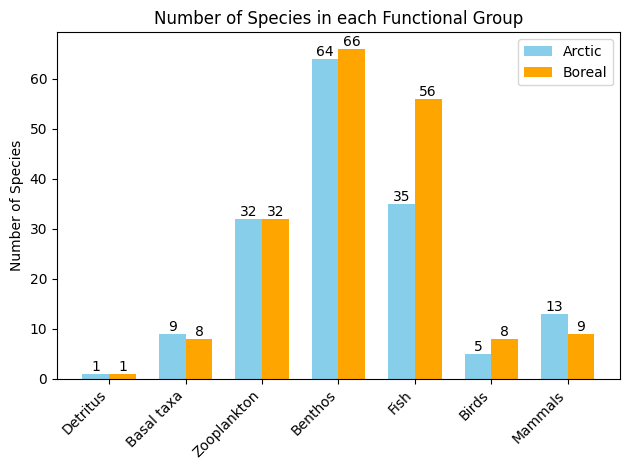

In [43]:
# checking group assignments:

def functional_assignment(G, node_id):
    functional_group = G.nodes[node_id]['functional_group']
    print(f"Node {node_id} belongs to the {functional_group} functional group")

# functional_assignment(arcticGraph, 0)
# functional_assignment(arcticGraph, 1)
# functional_assignment(arcticGraph, 106)
# print("")
# functional_assignment(borealGraph, 0)
# functional_assignment(borealGraph, 171)
# functional_assignment(borealGraph, 169)

arctic_counts = {group: sum(1 for _, data in arcticGraph.nodes(data=True) if data['functional_group'] == group) for group in func_group}
boreal_counts = {group: sum(1 for _, data in borealGraph.nodes(data=True) if data['functional_group'] == group) for group in func_group}

# Prepare data for plotting
arctic_values = [arctic_counts[group] for group in func_group]
boreal_values = [boreal_counts[group] for group in func_group]

fig, ax = plt.subplots()
x = range(len(func_group))
width = 0.35

arctic_bars = ax.bar([i - width/2 for i in x], arctic_values, width, label='Arctic', color='skyblue')
boreal_bars = ax.bar([i + width/2 for i in x], boreal_values, width, label='Boreal', color='orange')

# Add count labels on top of each bar
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height,
                f'{height}', ha='center', va='bottom')

add_labels(arctic_bars)
add_labels(boreal_bars)

ax.set_ylabel('Number of Species')
ax.set_title('Number of Species in each Functional Group')
ax.set_xticks(x)
ax.set_xticklabels(func_group, rotation=45, ha='right')
ax.legend()
plt.tight_layout()
plt.show()

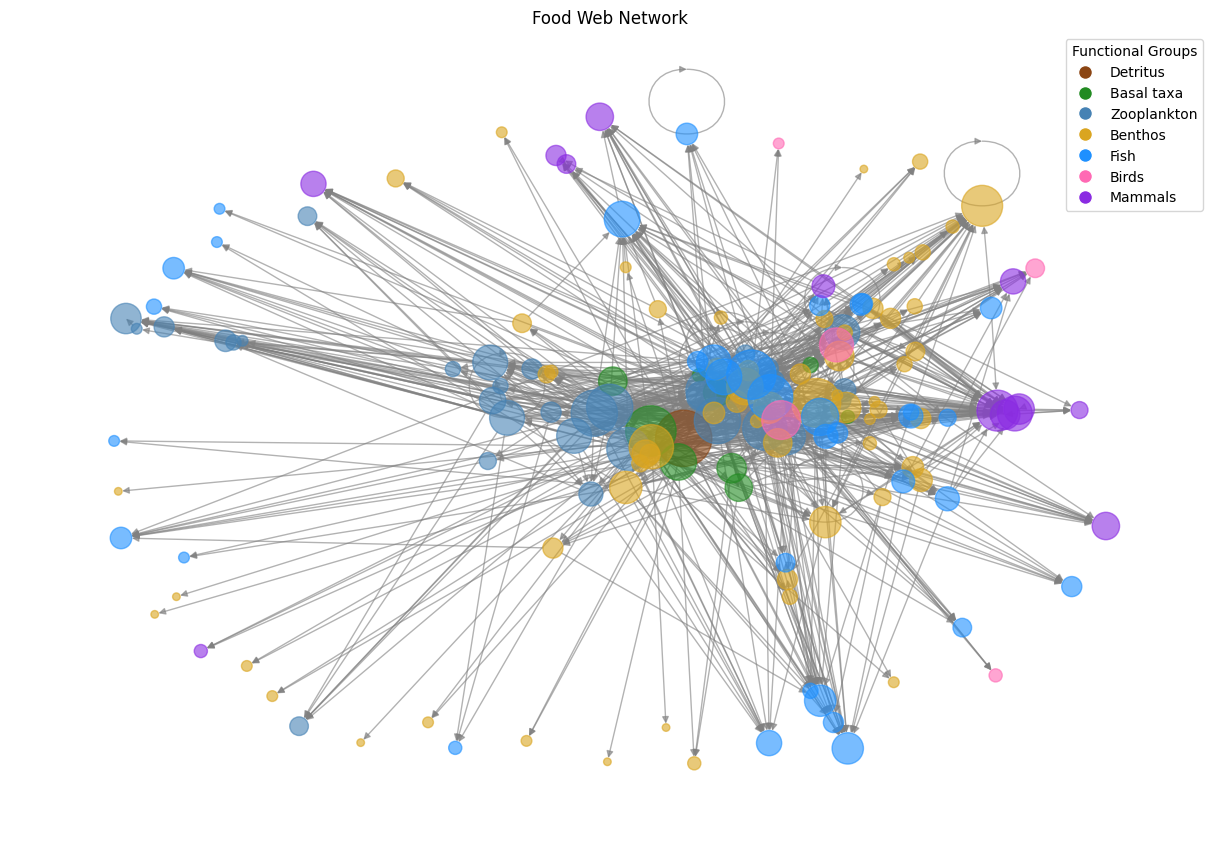

In [44]:
# Graph with node size based on degree and color showing the corresponding functional group 

func_groups = {
    "Detritus": "#8B4513",  # Brown
    "Basal taxa": "#228B22",  # Forest Green
    "Zooplankton": "#4682B4",  # Steel Blue
    "Benthos": "#DAA520",  # Goldenrod
    "Fish": "#1E90FF",  # Dodger Blue
    "Birds": "#FF69B4",  # Hot Pink
    "Mammals": "#8A2BE2"  # Blue Violet
}


node_colors = []
for node in arcticGraph.nodes():
    if node == 0:
        group = "Detritus"
    elif 1 <= node <= 9:
        group = "Basal taxa"
    elif 10 <= node <= 41:
        group = "Zooplankton"
    elif 42 <= node <= 105:
        group = "Benthos"
    elif 106 <= node <= 140:
        group = "Fish"
    elif 141 <= node <= 145:
        group = "Birds"
    else:
        group = "Mammals"
    node_colors.append(func_groups[group])

# Calculate node sizes based on degree
node_sizes = [arcticGraph.degree(node) * 30 for node in arcticGraph.nodes()]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(arcticGraph)
nx.draw(arcticGraph, pos, node_color=node_colors, node_size=node_sizes, with_labels=False, edge_color='gray', alpha=0.6)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=group, markerfacecolor=color, markersize=10)
                   for group, color in func_groups.items()]
plt.legend(handles=legend_elements, loc='upper right', title="Functional Groups")

plt.title("Food Web Network")
plt.axis('off')
plt.show()

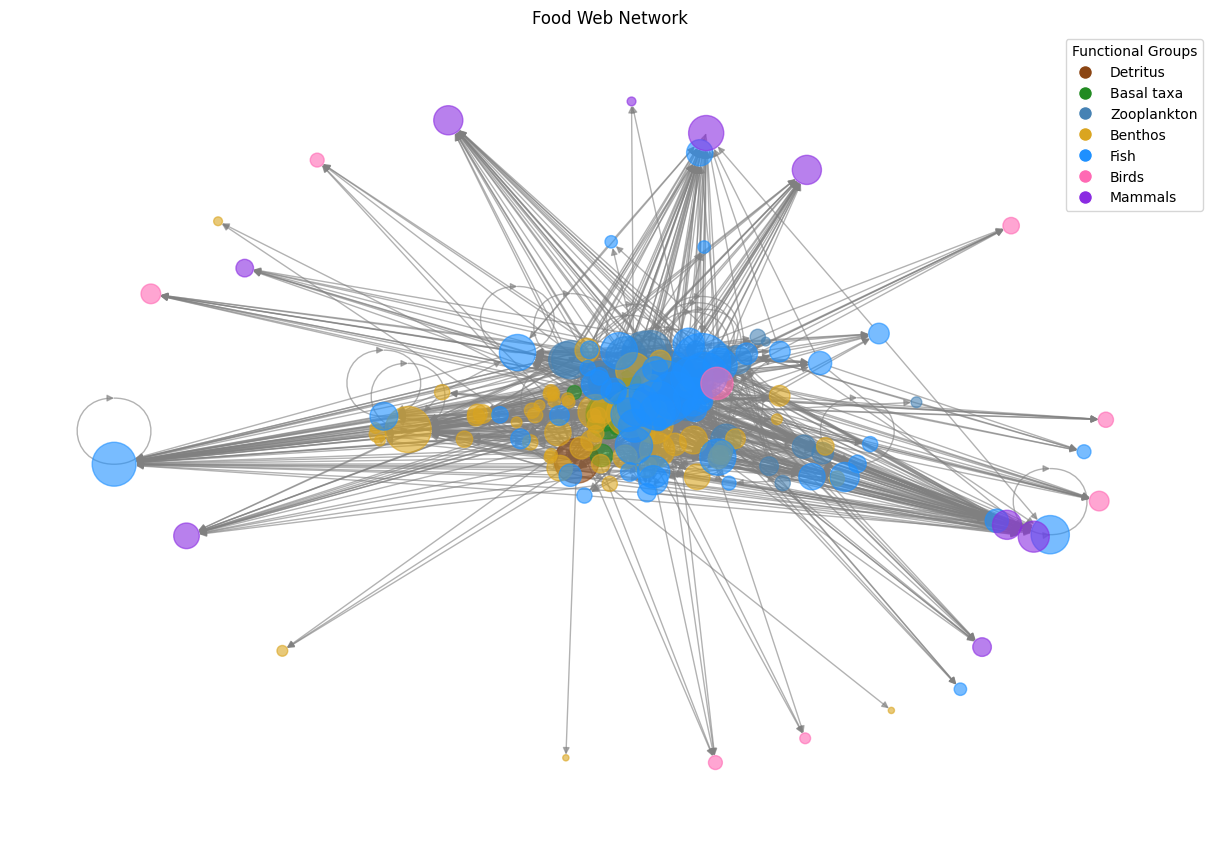

In [45]:
node_colors = []
for node in borealGraph.nodes():
    if node == 0:
        group = "Detritus"
    elif 1 <= node <= 8:
        group = "Basal taxa"
    elif 9 <= node <= 40:
        group = "Zooplankton"
    elif 41 <= node <= 106:
        group = "Benthos"
    elif 107 <= node <= 162:
        group = "Fish"
    elif 163 <= node <= 170:
        group = "Birds"
    else:
        group = "Mammals"
    node_colors.append(func_groups[group])

# Calculate node sizes based on degree
node_sizes = [borealGraph.degree(node) * 20 for node in borealGraph.nodes()]

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(borealGraph)
nx.draw(borealGraph, pos, node_color=node_colors, node_size=node_sizes, with_labels=False, edge_color='gray', alpha=0.6)

# Add a legend
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=group, markerfacecolor=color, markersize=10)
                   for group, color in func_groups.items()]
plt.legend(handles=legend_elements, loc='upper right', title="Functional Groups")

plt.title("Food Web Network")
plt.axis('off')
plt.show()

## Food Web Degree Distributions 

In [ ]:
boreal_in_degree = dict(borealGraph.in_degree())
boreal_out_degree = dict(borealGraph.out_degree())

arctic_in_degree = dict(arcticGraph.in_degree())
arctic_out_degree = dict(arcticGraph.out_degree())

arctic_ii_in_degree = dict(arctic_ii_graph.in_degree())
arctic_ii_out_degree = dict(arctic_ii_graph.out_degree())

# Function to create cumulative distribution
def cumulative_distribution(degrees):
    values = sorted(set(degrees.values()), reverse=True)
    hist = [sum(1 for d in degrees.values() if d >= i) for i in values]
    return values, hist

# Calculate cumulative distributions
boreal_in_values, boreal_in_hist = cumulative_distribution(boreal_in_degree)
boreal_out_values, boreal_out_hist = cumulative_distribution(boreal_out_degree)

arctic_in_values, arctic_in_hist = cumulative_distribution(arctic_in_degree)
arctic_out_values, arctic_out_hist = cumulative_distribution(arctic_out_degree)

arctic_ii_in_values, arctic_ii_in_hist = cumulative_distribution(arctic_ii_in_degree)
arctic_ii_out_values, arctic_ii_out_hist = cumulative_distribution(arctic_ii_out_degree)

# Create log-linear plots
plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(boreal_in_values, boreal_in_hist, 'bo', label="boreal",)
plt.plot(arctic_in_values, arctic_in_hist, 'ro', label="arctic")
plt.plot(arctic_ii_in_values, arctic_ii_in_hist, 'go', label="arctic II")
plt.yscale('log')
plt.xlabel('Number of prey (in-degree)')
plt.ylabel('log cumulative in-degree')
plt.title('In-degree Distribution')
plt.legend()

plt.subplot(122)
plt.plot(boreal_out_values, boreal_out_hist, 'bo', label="boreal",)
plt.plot(arctic_out_values, arctic_out_hist, 'ro', label="arctic")
plt.plot(arctic_ii_out_values, arctic_ii_out_hist, 'go', label="arctic II")
plt.yscale('log')
plt.xlabel('Number of predators (out-degree)')
plt.ylabel('log cumulative out-degree')
plt.title('Out-degree Distribution')
plt.legend()

plt.tight_layout()
plt.show()

## Topological Roles

In [ ]:
z_score = 

## DCSBM Aaron was talking about using

In [ ]:
def dcsbm_LogL(wrs,kpr):
    # DO NOT MODIFY THIS FUNCTION
    # This function calculates the log-likelihood of the degree-corrected stochastic block model (DC-SBM)
    # See Eq. (9) in Lecture 6.
    #
    # input  : wrs is a c x c np.array of stub counts
    #        : kpr is a c x 1 np.array of stub counts 
    # output : the dcsbm log-likelihood
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted

    c = wrs.shape[1]  # number of groups
    
    logL = 0
    for r in range(c):
        for s in range(c):
            if wrs[r,s] < 1 or kpr[r] < 1 or kpr[s] < 1:
                temp = 0 # define 0^0 = 1
            else:
                temp = wrs[r,s]*np.log( wrs[r,s] / (kpr[r]*kpr[s]) )
            logL = logL + temp
    
    return logL
    # DO NOT MODIFY THIS FUNCTION

In [ ]:
def tabulate_wk(G,z,c):
    # This function tabulates the w_rs and kappa_r auxiliary data structures for the DC-SBM
    #
    # input  : G is simple graph with n nodes
    #        : z is a dictionary of group labels for G's nodes, into c groups
    #        : c is scalar, number of possible groups
    # output : wrs, kpr
    # 
    # WARNING: function is optimistic: assumes inputs are properly formatted
    
    wrs = np.zeros([c,c]) # count of stubs from group r to group s
    kpr = np.zeros([c,1]) # total degree of group r

    ##### do not modify above here #####

    
    ### YOUR CODE
    edges = list(G.edges())
    for e in edges:
        r = z[int(e[0])]
        s = z[int(e[1])]
        # print(f'edge {e} --> z{r,s}')
        wrs[r,s] = wrs[r,s] + 1
        wrs[s,r] = wrs[s,r] + 1     
    kpr = np.sum(wrs,axis=1) # do row sums of wrs 
        
    ##### do not modify below here #####

    return wrs,kpr

In [ ]:
# wrs,kpr = tabulate_wk(borealGraph,z,c)
# thisL = dcsbm_LogL(wrs,kpr)

In [ ]:
def calculateHamiltonian(graph, adjacency, spins, c, gamma):
    firstLoop = 0
    M = graph.number_of_edges()
    for i in range(len(adjacency[0])):
        for j in range(len(adjacency[0])):
            if (adjacency[i][j] > 0):
                if (spins[i] == spins[j]):
                    firstLoop += 1

    constant = gamma / (2 * M)
    
    secondLoop = 0
    for i in range(c):
        Ks = 0
        for j in spins.keys():
            if (spins[j] == i):
                Ks += graph.degree(j)
        secondLoop += (pow(Ks, 2) / 2)

    secondLoop *= constant
        
    return ((-1 * firstLoop) + secondLoop)

In [ ]:
def changeInEnergy(graph, adjacency, spins, l, phi, alpha, gamma):
    if (phi == alpha):
        return "phi cannot equal alpha"
    
    first = 0
    for j in range(len(adjacency[0])):
        if (j != l): 
            if (phi == spins[j]):
                first += (adjacency[l][j])

    totalEdgeCount = 0
    for i in range(len(adjacency[0])):
        for j in range(len(adjacency[0])):
            totalEdgeCount += adjacency[i][j]

    totalEdgeCount *= 2
    
    groupEdgeCountPhi = 0
    groupEdgeCountAlpha = 0
    for i in spins.keys():
        if (spins[i] == phi):
            groupEdgeCountPhi += graph.degree(i)
        if (spins[i] == alpha):
            groupEdgeCountAlpha += graph.degree(i)
    second = gamma * (graph.degree(l) / totalEdgeCount) * (groupEdgeCountPhi - graph.degree(l))

    third = 0
    for j in range(len(adjacency[0])):
        if (j != l):
            if (alpha == spins[j]):
                third += adjacency[l][j]

    fourth = gamma * (graph.degree(l) / totalEdgeCount) * groupEdgeCountAlpha

    # print(first, second, third, fourth)
    return (first - second - third + fourth)

In [ ]:
class Solution:
    def __init__(self, value, spins):
        self.value = value
        self.spins = spins

In [ ]:
time = list(range(100))
temperature = [2/(tt+1)**.8 for tt in time]
paccept = [np.exp(-0.2/temp) for temp in temperature]

plt.plot(time, paccept)
plt.ylim([0,1])
plt.show()

In [ ]:
def schedule(time):
    C = 2
    p = 0.8
    temperature = C/(time+1)**p

    return temperature

In [ ]:
def simulatedAnnealing(graph, adjacency, c, gamma):
    t = 0
    T = schedule(t)
    Tmin = 0.14
    numIterations = 1000
    numNodes = len(graph.nodes())

    spins = {}
    for i in range(len(adjacency[0])):
        spins[i] = np.random.choice(range(c))

    minimumSol = Solution(float('inf'), None)
    currentSol = Solution(calculateHamiltonian(graph, adjacency, spins, c, gamma), spins)

    #stopCounter = 0
    while (T > Tmin):
        print(T)
        #print("stop counter: ", stopCounter)
        #if (stopCounter > 15):
            #return minimumSol
        for i in range(numIterations):
                
            if (currentSol.value < minimumSol.value):
                minimumSol = currentSol
                #stopCounter = 0
                print(minimumSol.value)

            l = np.random.choice(list(range(numNodes)))
            minimumChange = float('inf')
            minimumIndex = ()
            for i in range(c):
                if (i != currentSol.spins[l]):
                    workingChange = changeInEnergy(graph, adjacency, currentSol.spins, l, currentSol.spins[l], i, gamma)
                    if (workingChange < minimumChange):
                        minimumChange = workingChange
                        minimumIndex = (currentSol.spins[l], i)

            newSpins = currentSol.spins.copy()
            newSpins[l] = minimumIndex[1]
            newSol = Solution(calculateHamiltonian(graph, adjacency, newSpins, c, gamma), newSpins)

            ap = math.exp((currentSol.value - newSol.value) / T)
            if (ap > random.uniform(0, 1)):
                currentSol = newSol

        t += 1
        T = schedule(t)
        #stopCounter += 1
        # print(T)
    
    return minimumSol

In [ ]:
minimumSolBoreal = simulatedAnnealing(borealGraph, borealAdjacencySym, 4, 1)
print(minimumSol.spins)
print(minimumSol.value)

In [ ]:
minimumSolArctic = simulatedAnnealing(arcticGraph, arcticAdjacencySym, 5, 1)
print(minimumSol.spins)
print(minimumSol.value)

In [ ]:
def calculateModularity(graph, spins, c):
    L = graph.number_of_edges()
    total = 0
    numNodes = len(graph.nodes())
    for s in range(c):
        group = []
        for i in range(numNodes):
            if (spins[i] == s):
                group.append(i)

        linksBetweenS = 0
        for i in group:
            for j in list(graph.edges(i)):
                if (j[1] in group):
                    linksBetweenS += 1

        sumDegrees = 0
        for i in group:
            sumDegrees += graph.degree(i)

        total += ((linksBetweenS / L) - pow((sumDegrees / (2 * L)), 2))

    return total

In [ ]:
modularityBoreal = calculateModularity(borealGraph, minimumSolBoreal.spins, 4)
print(modularityBoreal)

In [ ]:
modularityArctic = calculateModularity(arcticGraph, minimumSolArctic.spins, 5)
print(modularityArctic)

In [ ]:
saveBoreal = False
if (saveBoreal):
    saveGroupBoreal = open("groupsBoreal.txt", "a")
    saveGroupBoreal.write("{")
    
    for i in minimumSolBoreal.spins.keys():
        saveGroupBoreal.write(str(i) + ": " + str(minimumSolBoreal.spins[i]) + ", ")
        
    saveGroupBoreal.write("}")

In [ ]:
saveArctic = False
if (saveArctic):
    saveGroupArctic = open("groupsArctic.txt", "a")
    saveGroupArctic.write("{")
    
    for i in minimumSolArctic.spins.keys():
        saveGroupArctic.write(str(i) + ": " + str(minimumSolArctic.spins[i]) + ", ")
        
    saveGroupArctic.write("}")

In [ ]:
def loadSpinsFromTxt(path):
    spinsFromFile = {}
    file = open(path, "r")
    line = file.read()

    index = 0
    for i in range(len(line)):
        if (line[i] == ':'):
            if (index < 10):
                spinsFromFile[int(line[i - 1])] = int(line[i + 2])
            elif (index < 100):
                first = int(line[i - 2] + line[i - 1])
                spinsFromFile[first] = int(line[i + 2])
            elif (index < 1000):
                first = int(line[i - 3] + line[i - 2] + line[i - 1])
                spinsFromFile[first] = int(line[i + 2])
            index += 1

    return spinsFromFile
        
    
    #Solution(calculateHamiltonian(graph, adjacency, spins, c, gamma), )

borealSpins = loadSpinsFromTxt("groupsBoreal.txt")
print(borealSpins)

In [ ]:
def calculateZ(graph, spins, i):
    j = spins[i]
    partners = [i]
    k = []
    
    for x in spins.keys():
        if (spins[x] == j):
            partners.append(x)

    for x in range(len(partners)):
        k.append(0)
        for y in graph.edges(partners[x]):
            if (y[1] in partners):
                k[x] += 1

    kis = k[0]
    kMean = sum(k) / len(k)
    SDks = statistics.stdev(k)

    return (kis - kMean) / SDks

In [ ]:
borealZ = {}
for i in borealSpins.keys():
    borealZ[i] = calculateZ(borealGraph, borealSpins, i)     

print(borealZ)

In [ ]:
def calculatePC(graph, spins, i, c):
    ki = graph.degree(i)

    summation = 0
    for j in range(c):
        partners = []
        for x in spins.keys():
            if (spins[x] == j):
                partners.append(x)

        kit = 0
        for x in graph.edges(i):
            if (x[1] in partners):
                kit += 1

        summation += pow((kit / ki), 2)

    return (1 - summation)

In [ ]:
borealPC = {}
for i in borealSpins.keys():
    borealPC[i] = calculatePC(borealGraph, borealSpins, i, 4)

print(borealPC)